## GEOM7001 Flood Mapping Before and After Cyclone Debbie - Sentinel-2 MSI Imagery
This script lists the workflow for delineating flood inundation caused by Cyclone Debbie in March 2017 using optical imagery from Sentinel-2.
The workflow includes before and after images using Green and SWIR bands to calculate MNDWI.

### Load packages

In [92]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb
from dea_tools.datahandling import load_reproject

import rioxarray #reprojecting to Albers
import odc.geo.xr #reprojecting to Albers

from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map, xr_animation
from datacube.utils.masking import mask_invalid_data # reprojecting to Albers

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

### Connect to the datacube

In [33]:
dc = datacube.Datacube(app="GEOM7001_Project")

### Set up a dask cluster

In [34]:
create_local_dask_cluster()

/env/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46283 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/s4610425@student.uq.edu.au/proxy/46283/status,
Dashboard: /user/s4610425@student.uq.edu.au/proxy/46283/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35529,Workers: 1
Dashboard: /user/s4610425@student.uq.edu.au/proxy/46283/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:41143,Total threads: 2
Dashboard: /user/s4610425@student.uq.edu.au/proxy/42493/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:34027,


### Load data from datacube with parameters

In [93]:
from dea_tools.datahandling import load_ard

# Define your spatial and temporal extent
lon_range = (150.41, 150.55)
lat_range = (-23.29, -23.45)
before_date = "2017-02-17"
after_date   = "2017-04-08"

# Create query object
query = {
    "x": lon_range,
    "y": lat_range,
    "resolution": (-10, 10),       # 10m resolution to match nbart_nir_1
    "time": (start_date, end_date),
    "output_crs": "EPSG:3577",
    "dask_chunks": {"time": 1, "x": 512, "y": 512},  # optional, adjust to your memory
}

# Load Sentinel-2A with s2cloudless cloud masking
ds = load_ard(
    dc=dc,
    products=["ga_s2am_ard_3"],
    measurements=["nbart_swir_2", "nbart_nir_1", "nbart_red", "nbart_green", "nbart_blue", "oa_s2cloudless_prob"],
    cloud_mask="s2cloudless", # cloud mask
    min_gooddata=0.9,  # only keep pixels where 90% of the time step is cloud-free
    group_by="solar_day",
    **query
)

Finding datasets
    ga_s2am_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 2 out of 6 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Returning 2 time steps as a dask array


In [140]:
# Check data
print(ds)

<xarray.Dataset> Size: 184MB
Dimensions:              (time: 2, y: 1976, x: 1661)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2017-02-17T00:12:07.463000...
  * y                    (y) float64 16kB -2.645e+06 -2.645e+06 ... -2.665e+06
  * x                    (x) float64 13kB 1.856e+06 1.856e+06 ... 1.872e+06
    spatial_ref          int32 4B 3577
Data variables:
    nbart_swir_2         (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nbart_nir_1          (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nbart_red            (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nbart_green          (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nbart_blue           (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    oa_s2cloudless_prob  (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np

In [144]:
# # DO NOT USE - EXPORT SINGLE TIME STEP FRO REAMPLING IN SAR
# import rioxarray

# ds_before = ds.isel(time=0)[["nbart_red"]]
# ds_before.rio.write_crs("EPSG:3577", inplace=True)
# ds_before.rio.to_raster("s2_before_ref.tif")


### Visualise RGB Before and After

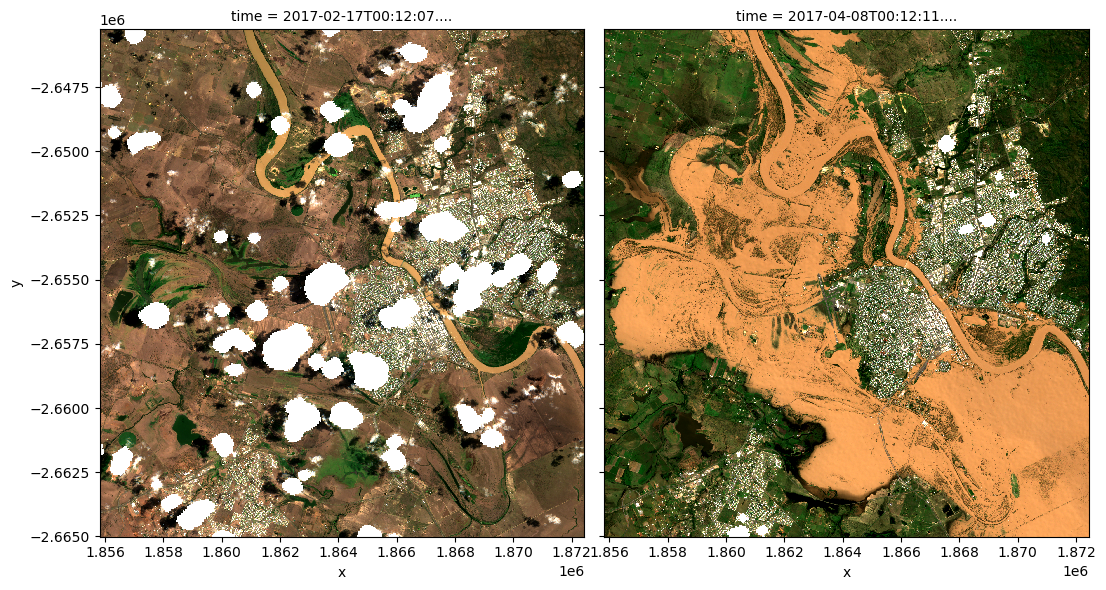

In [95]:
from dea_tools.plotting import rgb
rgb(ds, bands=["nbart_red","nbart_green","nbart_blue"], col="time", col_wrap=3, robust=True)

### Calculate MNDWI Index

In [106]:
# Calculate MNDWI and add it to the loaded data set
ds['mndwi'] = (ds.nbart_green - ds.nbart_swir_2) / (ds.nbart_green + ds.nbart_swir_2)

# Check that MNDWI has been added to dataset
ds

<xarray.Dataset> Size: 184MB
Dimensions:              (time: 2, y: 1976, x: 1661)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2017-02-17T00:12:07.463000...
  * y                    (y) float64 16kB -2.645e+06 -2.645e+06 ... -2.665e+06
  * x                    (x) float64 13kB 1.856e+06 1.856e+06 ... 1.872e+06
    spatial_ref          int32 4B 3577
Data variables:
    nbart_swir_2         (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nbart_nir_1          (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nbart_red            (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nbart_green          (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nbart_blue           (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    oa_s2cloudless_prob  (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    mndwi                (time, y, x) float32 26MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Plot MNDWI Before and After

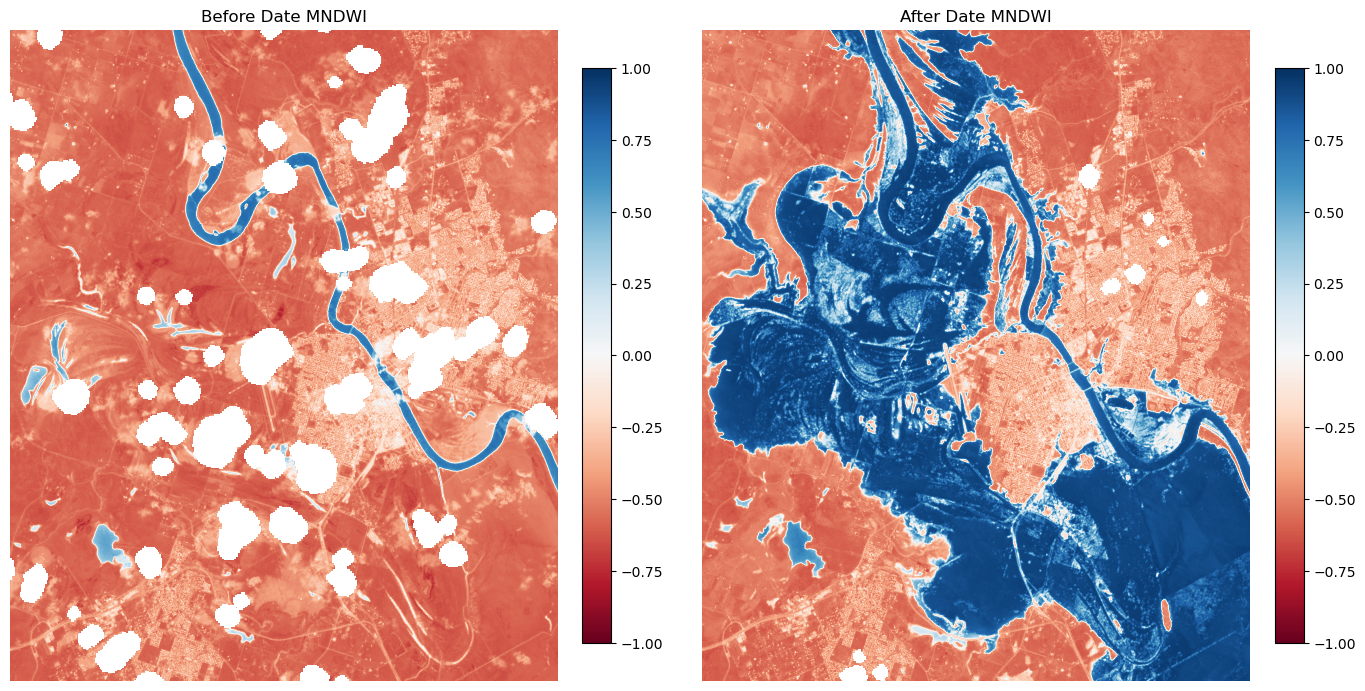

In [109]:
# Select before and after dates
before_date_ds = ds.isel(time=0)
after_date_ds  = ds.isel(time=-1)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Before date MNDWI
m = axes[0].imshow(before_date_ds['mndwi'], cmap='RdBu', vmin=-1, vmax=1)
axes[0].set_title("Before Date MNDWI")
axes[0].axis('off')
fig.colorbar(m, ax=axes[0], fraction=0.046, pad=0.04)

# After date MNDWI
m = axes[1].imshow(after_date_ds['mndwi'], cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title("After Date MNDWI")
axes[1].axis('off')
fig.colorbar(m, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Apply Otsu threshold

Otsu threshold (same for both): 0.13875246


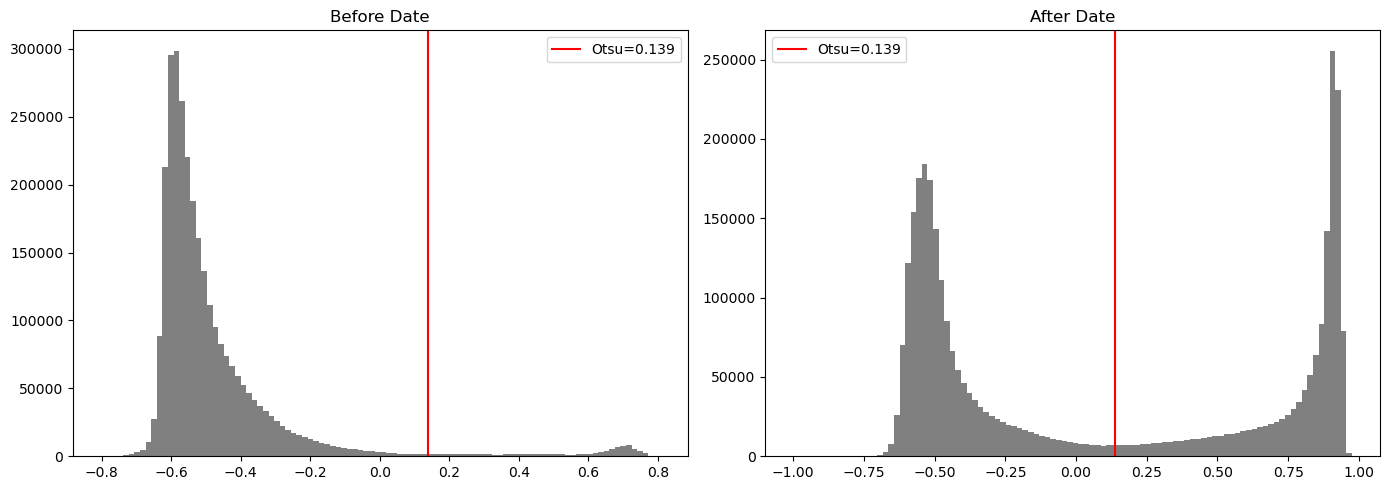

In [119]:
from skimage.filters import threshold_otsu

# Get MNDWI for before and after dates
mndwi_before = ds['mndwi'].isel(time=0).values
mndwi_after  = ds['mndwi'].isel(time=-1).values

# Flatten and remove NaNs
pixels_before = mndwi_before[~np.isnan(mndwi_before)].flatten()
pixels_after  = mndwi_after[~np.isnan(mndwi_after)].flatten()

# Stack both arrays
all_pixels = np.concatenate([pixels_before, pixels_after])

# Compute a single Otsu threshold
otsu_threshold = threshold_otsu(all_pixels)
print("Otsu threshold (same for both):", otsu_threshold)

# Optional: visualize histograms with threshold
fig, axes = plt.subplots(1, 2, figsize=(14,5))
axes[0].hist(pixels_before, bins=100, color='grey')
axes[0].axvline(otsu_threshold, color='red', label=f"Otsu={otsu_threshold:.3f}")
axes[0].set_title("Before Date")
axes[0].legend()

axes[1].hist(pixels_after, bins=100, color='grey')
axes[1].axvline(otsu_threshold, color='red', label=f"Otsu={otsu_threshold:.3f}")
axes[1].set_title("After Date")
axes[1].legend()

plt.tight_layout()
plt.show()


In [116]:
# Threshold for binarizing water and non-water
otsu_threshold = 0.13875246

### Defining water and non-water from Otsu thresholds for MNDWI

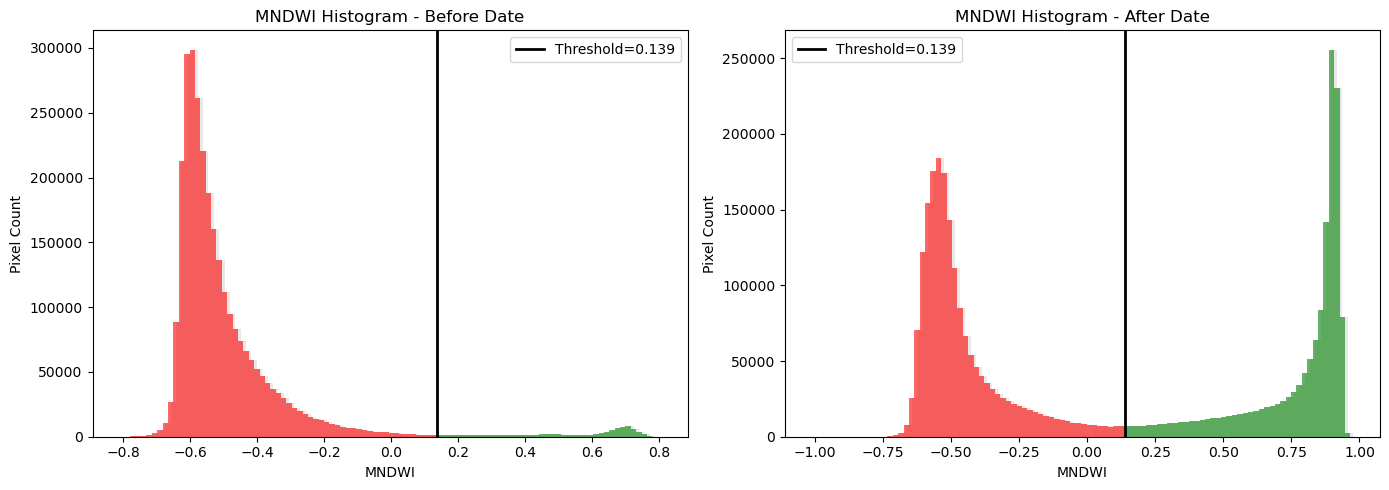

In [118]:
# Flatten and remove NaNs
pixels_before = mndwi_before[~np.isnan(mndwi_before)].flatten()
pixels_after  = mndwi_after[~np.isnan(mndwi_after)].flatten()

# Function to plot histogram with shading
def plot_histogram_shaded(pixels, threshold, ax, title, water_color='green', non_water_color='red'):
    # Histogram
    counts, bins, _ = ax.hist(pixels, bins=100, color='lightgray', alpha=0.5)
    
    # Shade non-water
    ax.bar(bins[:-1][bins[:-1] <= threshold], counts[bins[:-1] <= threshold],
           width=bins[1]-bins[0], color=non_water_color, alpha=0.6)
    
    # Shade water
    ax.bar(bins[:-1][bins[:-1] > threshold], counts[bins[:-1] > threshold],
           width=bins[1]-bins[0], color=water_color, alpha=0.6)
    
    # Threshold line
    ax.axvline(threshold, color='black', linewidth=2, label=f"Threshold={threshold:.3f}")
    
    ax.set_title(title)
    ax.set_xlabel("MNDWI")
    ax.set_ylabel("Pixel Count")
    ax.legend()

# Plot before and after
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_histogram_shaded(pixels_before, otsu_threshold, axes[0], "MNDWI Histogram - Before Date")
plot_histogram_shaded(pixels_after, otsu_threshold, axes[1], "MNDWI Histogram - After Date")
plt.tight_layout()
plt.show()

### Build and apply classifier

In [128]:
def create_water_mask_mndwi(mndwi_array, threshold):
    """
    Returns a binary water mask from MNDWI values.
    1 = water
    0 = non-water
    NaN pixels remain NaN.
    """
    mask = np.zeros_like(mndwi_array, dtype=np.uint8)
    mask[(mndwi_array > threshold) & np.isfinite(mndwi_array)] = 1
    return mask

# Apply to before and after dates
water_before_mask = create_water_mask_mndwi(ds['mndwi'].isel(time=0).values, otsu_threshold)
water_after_mask  = create_water_mask_mndwi(ds['mndwi'].isel(time=-1).values, otsu_threshold)

# Check Classifiers
print("Printed array of water_before_mask: ", water_before_mask)
print("Printed array of water_after_mask: ", water_after_mask)

Printed array of water_before_mask:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Printed array of water_after_mask:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


### Visualise flood delineation
0 = Non-water
1 = Water

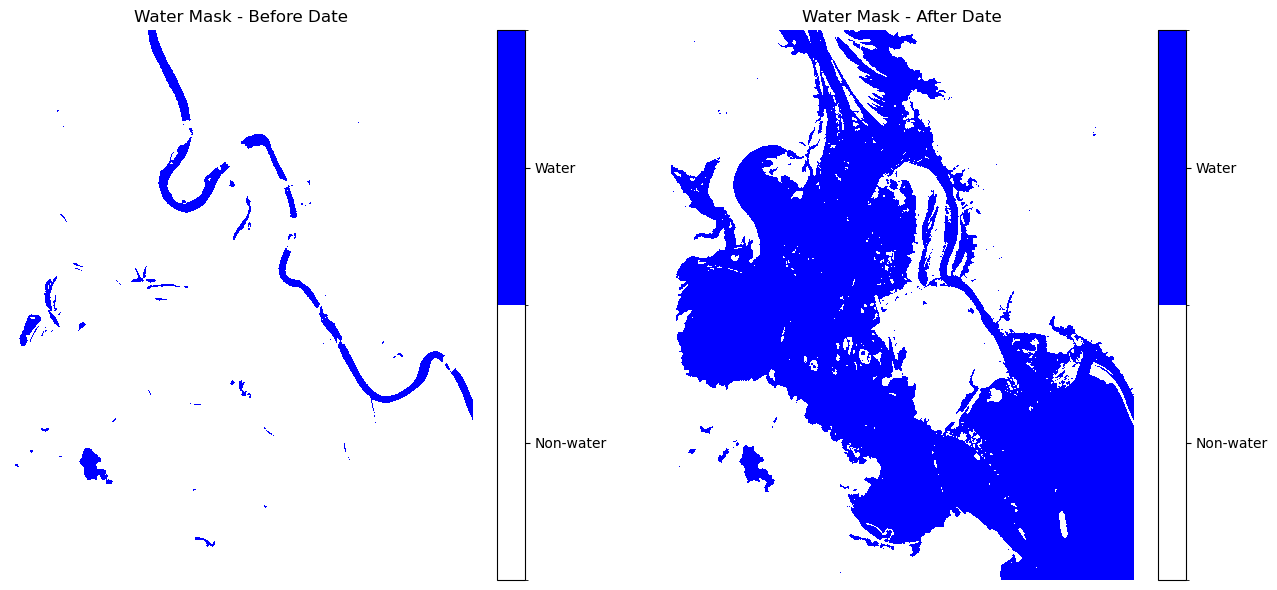

In [133]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a two-color colormap: 0 = red (non-water), 1 = green (water)
cmap = mcolors.ListedColormap(['white', 'blue'])
bounds = [0, 0.5, 1]  # define boundaries for the two values
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Before Water Mask ---
im0 = axes[0].imshow(water_before_mask, cmap=cmap, norm=norm)
axes[0].set_title("Water Mask - Before Date")
axes[0].axis("off")
cbar0 = fig.colorbar(im0, ax=axes[0], ticks=[0.25, 0.75], fraction=0.046, pad=0.04)
cbar0.ax.set_yticklabels(['Non-water', 'Water'])

# --- After Water Mask ---
im1 = axes[1].imshow(water_after_mask, cmap=cmap, norm=norm)
axes[1].set_title("Water Mask - After Date")
axes[1].axis("off")
cbar1 = fig.colorbar(im1, ax=axes[1], ticks=[0.25, 0.75], fraction=0.046, pad=0.04)
cbar1.ax.set_yticklabels(['Non-water', 'Water'])

plt.tight_layout()
plt.show()


### Create flood map with both existing water and flooded water for MNDWI

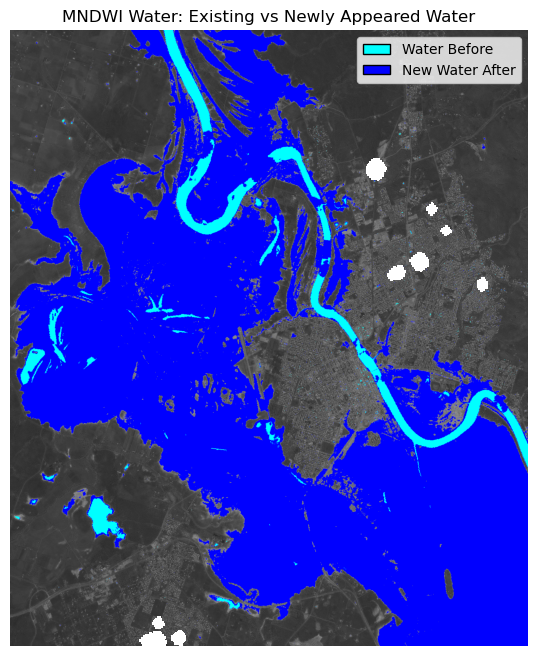

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Determine newly appeared water (after but not before)
new_water_mask = (after_water_mask == 1) & (before_water_mask == 0)

# Create grayscale RGB background from before-date MNDWI
rgb = np.stack([mndwi_after, mndwi_after, mndwi_after], axis=-1)

# Normalize to 0-1 for plotting
rgb_min, rgb_max = np.nanmin(rgb), np.nanmax(rgb)
rgb = (rgb - rgb_min) / (rgb_max - rgb_min)

# Highlight existing water in cyan
rgb[(before_water_mask == 1) & (new_water_mask == 0)] = [0, 1, 1]  # cyan

# Highlight newly appeared water in blue
rgb[new_water_mask] = [0, 0, 1]  # blue

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("MNDWI Water: Existing vs Newly Appeared Water")
plt.axis("off")

# Create legend
legend_elements = [
    Patch(facecolor='cyan', edgecolor='k', label='Water Before'),
    Patch(facecolor='blue', edgecolor='k', label='New Water After')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()